In [1]:
### Loading the Boston housing dataset
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#looking at the data
print(train_data.shape)
print(test_data.shape)

#the targets are the median values of owner-occupied homes, in thousands of dollars
print(train_targets)

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 

**Preparando os dados**

In [2]:
### Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

**Construindo a rede**
Devido ao número limitado de amostras disponíveis, usaremos uma rede muito pequena com duas camadas ocultas, cada uma com 64 unidades. Em geral, quanto menos dados de treinamento houver, pior será o *overfitting*, e usar uma rede pequena é uma maneira de mitigar o *overfitting*.

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
from keras import models
from keras import layers
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

A rede termina com uma única unidade e sem ativação (será uma camada linear). Essa é uma configuração típica para regressão escalar (uma regressão em que você está tentando prever um único valor contínuo). Aplicar uma função de ativação restringiria o intervalo que a saída pode assumir; por exemplo, se você aplicasse uma função de ativação `sigmoid` à última camada, a rede só poderia aprender a prever valores entre 0 e 1. Aqui, porque a última camada é puramente linear, a rede está livre para aprender a prever valores em qualquer faixa.

Observe que estamos compilando a rede com a função de perda `mse` (*erro médio quadrático*), o quadrado da diferença entre as previsões e os alvos. Esta é uma função de perda amplamente utilizada para problemas de regressão.
Também estamos monitorando uma nova métrica durante o treinamento: o *erro médio absoluto* (`MAE`). É o valor absoluto da diferença entre as previsões e os alvos. Por exemplo, um `MAE` de 0.5 neste problema significaria que suas previsões têm um desvio médio de $500.

**Validando a abordagem usando validação K-fold**

Para avaliar sua rede enquanto continua ajustando seus parâmetros (como o número de épocas usado para o treinamento), você poderia dividir os dados em um conjunto de treinamento e um conjunto de validação, como fez nos exemplos anteriores. Mas, devido ao número limitado de pontos de dados, o conjunto de validação acabaria sendo muito pequeno (por exemplo, cerca de 100 exemplos). Como consequência, as pontuações de validação podem variar bastante dependendo de quais pontos de dados você escolheu para usar na validação e quais você escolheu para o treinamento: as pontuações de validação podem ter uma alta **variância** em relação à divisão de validação. Isso impediria que você avaliasse confiavelmente seu modelo.

A melhor prática em tais situações é usar a validação cruzada *K-fold*. Ela consiste em dividir os dados disponíveis em K partições (tipicamente K = 4 ou 5), instanciar K modelos idênticos e treinar cada um em K - 1 partições enquanto avalia na partição restante. A pontuação de validação para o modelo usado é então a média das K pontuações de validação obtidas. Em termos de código, isso é muito simples.

In [5]:
### K-fold validation
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
  epochs=num_epochs, batch_size=32, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
print(all_scores)
np.mean(all_scores)

processing fold # 0


C:\Users\gugat\PycharmProjects\PUC\venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3
[2.0134642124176025, 2.4808616638183594, 2.4920380115509033, 2.528165102005005]


2.3786322474479675

As diferentes execuções realmente mostram pontuações de validação bastante diferentes, de 2.6 a 3.2. A média (3.0) é uma métrica muito mais confiável do que qualquer pontuação única - esse é o ponto principal da validação cruzada K-fold. Neste caso, você está errando em média \$3000, o que é significativo considerando que os preços variam de \$10000 a \$50000.

Vamos tentar treinar a rede um pouco mais: 500 épocas. Para manter um registro de quão bem o modelo se sai a cada época, modificaremos o loop de treinamento para salvar o registro da pontuação de validação por época.

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


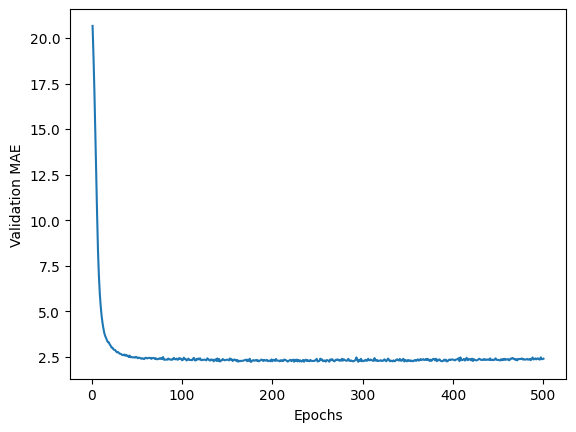

In [6]:
### Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
  epochs=num_epochs, batch_size=32, verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

### Building the history of successive mean K-fold validation scores
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Pode ser um pouco difícil ver o gráfico, devido a problemas de escala e variância relativamente alta. Vamos fazer o seguinte:
- Omitir os primeiros 10 pontos de dados, que estão em uma escala diferente do resto da curva.
- Substituir cada ponto por uma média móvel exponencial dos pontos anteriores para obter uma curva suave.

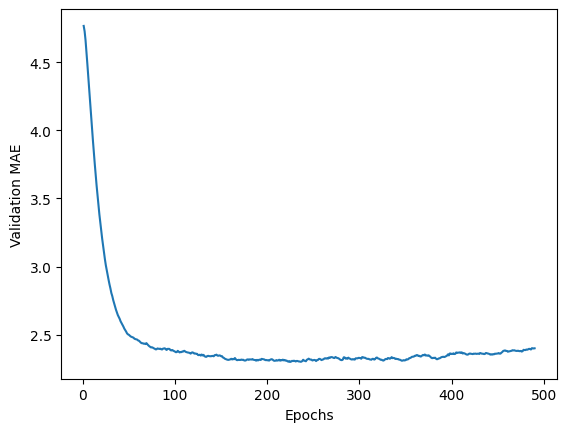

In [7]:
### Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

De acordo com este gráfico, a validação por MAE para de melhorar significativamente após 80 épocas. Após esse ponto, começa-se a ter *overfitting*. Assim que terminarmos de ajustar outros parâmetros do modelo (além do número de épocas, você também pode ajustar o tamanho das camadas ocultas), podemos treinar um modelo final em todos os dados de treinamento, com os melhores parâmetros, e então avaliar seu desempenho nos dados de teste.

In [8]:
### Training the final model
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=32, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

C:\Users\gugat\PycharmProjects\PUC\venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.1432 - mae: 2.7571 
2.9170806407928467


**Exercícios**

1. Aumente o número de camadas da rede. Qual é o efeito dessa mudança no *overfitting* da rede?


In [20]:
from tensorflow.keras import models, layers

from tensorflow.keras import models, layers
import numpy as np

class FlexibleModel:
    def __init__(self, input_shape, num_hidden_layers=3, units_per_layer=64, optimizer='rmsprop', loss='mse', metrics=['mae']):
        self.input_shape = input_shape
        self.num_hidden_layers = num_hidden_layers
        self.units_per_layer = units_per_layer
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics

    def build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(self.units_per_layer, activation='relu', input_shape=(self.input_shape,)))
        for _ in range(self.num_hidden_layers - 1):
            model.add(layers.Dense(self.units_per_layer, activation='relu'))
        model.add(layers.Dense(1))
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        return model

def eval_model_k_fold(num_hidden_layers, k=4, num_epochs=100):
    num_val_samples = len(train_data) // k
    all_scores = []
    
    print('Evaluating model with', num_hidden_layers, 'hidden layers')
    for i in range(k):
        # print('Processing fold #', i)
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
        
        model = FlexibleModel(train_data.shape[1], num_hidden_layers=num_hidden_layers).build_model()
        model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=32, verbose=0)
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_mae)
    
    mean_mae = np.mean(all_scores)
    print(f"Mean MAE over {k} folds with {num_hidden_layers} layers:", mean_mae)
    return mean_mae

In [21]:
possible_hidden_layers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mae_scores = [eval_model_k_fold(num_hidden_layers) for num_hidden_layers in possible_hidden_layers]
mae_scores

Evaluating model with 1 hidden layers
Mean MAE over 4 folds with 1 layers: 2.7634207010269165
Evaluating model with 2 hidden layers
Mean MAE over 4 folds with 2 layers: 2.4350287318229675
Evaluating model with 3 hidden layers
Mean MAE over 4 folds with 3 layers: 2.422805428504944
Evaluating model with 4 hidden layers
Mean MAE over 4 folds with 4 layers: 2.583626478910446
Evaluating model with 5 hidden layers
Mean MAE over 4 folds with 5 layers: 2.349538505077362
Evaluating model with 6 hidden layers
Mean MAE over 4 folds with 6 layers: 2.501535326242447
Evaluating model with 7 hidden layers
Mean MAE over 4 folds with 7 layers: 2.5029186010360718
Evaluating model with 8 hidden layers
Mean MAE over 4 folds with 8 layers: 3.1588295102119446
Evaluating model with 9 hidden layers
Mean MAE over 4 folds with 9 layers: 2.8831002712249756
Evaluating model with 10 hidden layers
Mean MAE over 4 folds with 10 layers: 3.117382287979126


[2.7634207010269165,
 2.4350287318229675,
 2.422805428504944,
 2.583626478910446,
 2.349538505077362,
 2.501535326242447,
 2.5029186010360718,
 3.1588295102119446,
 2.8831002712249756,
 3.117382287979126]

Analizando os resultados, podemos ver que o melhor número de camadas ocultas é 3, com um *MAE* médio de 2.42. A partir de 4 camadas ocultas, o *MAE* médio começa a aumentar, indicando *overfitting*.